## Steps:

1. Kitaiev Chain Hamiltonian

2. TFIM with spin chain on X direction and external field on Z

3. Jordan Weigner

4. Diagonalizing

5. Diagonalize with Particle hole symmetry


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import old.functions as f
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)
rc('animation', ffmpeg_path='C:\\Program Files (x86)\\ffmpeg\\bin\\ffmpeg.exe')
fps = 30
FFwriter=FFMpegWriter(fps=fps, extra_args=['-vcodec', 'libx264'])


### Energy levels diagram

Text(0, 0.5, 'Energy')

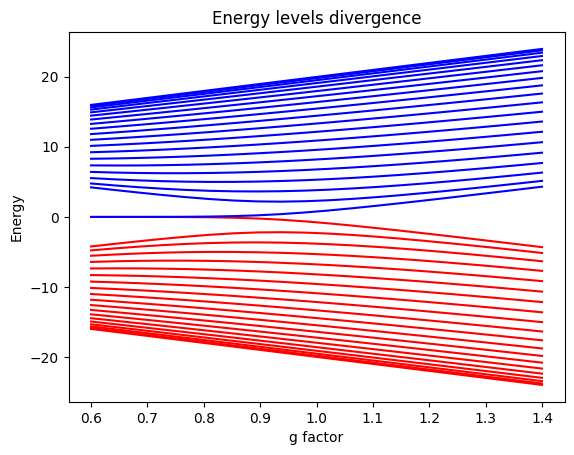

In [22]:
n = 20
mus = np.linspace(0.6,1.4,n)
res = []
for mu in mus:
    H = f.jordan_weigner(10, np.ones(n) * mu)
    evals, evecs = np.linalg.eig(H)
    m_evals = list(sorted(evals))
    res.append(np.array(m_evals))
res = np.array(res).T

for line in res:
    plt.plot(mus, line, 'b' if line[0] > 0 else 'r')
plt.title("Energy levels divergence")
plt.xlabel("g factor")
plt.ylabel("Energy")

In [ ]:
H = f.jordan_weigner(2, np.ones(30) * 0.5 + 4*np.array([1 if 10<i<20 else 0 for i in range(30)]))
evals, evecs = np.linalg.eig(H)
evecs = evecs.T
m_evals, m_evecs = zip(*sorted(zip(evals, evecs), key=lambda e: e[0] ** 2))

colors = [(1, 0, 0, 0.), (1, 0, 0, 0.1),(1, 0, 0, 0.2), (0, 0, 0, 1), (0, 0, 1, 0.2), (0, 0, 1, 0.1), (0, 0, 1, 0)]
colors = [(1, 0, 0, 0.2) , (0, 0, 0, 0.2) , (0, 0, 1, 0.2)]
cmap = colormap.from_list("bbr", colors, N=30)

# Show states
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(13, 5)
for i, (m, v) in list(enumerate(zip(m_evals, m_evecs))):
    ax1.axhline(m, c=cmap(0.5 + 0.5 * m / max(m_evals)))
    ax2.plot(f.project_phs_minus(m_evecs[i]), c=cmap(0.5 + 0.5 * m / max(m_evals)))
    ax2.plot(f.project_phs_plus(m_evecs[i]), c=cmap(0.5 + 0.5 * m / max(m_evals)))
plt.show()

# Show matrix
D = evecs.T @ H @ evecs
plt.imshow(H, cmap='bwr')
plt.title("H representation")
plt.show()




In [ ]:
n = 10
H = f.jordan_weigner(2, np.ones(n) * 0.5 + np.random.random(n) * 10)
evals, evecs = np.linalg.eig(H)
evecs = evecs.T
#evals, evecs = zip(*sorted(zip(evals, evecs), key=lambda e: e[0] ** 2))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(13, 5)
d = lambda i, j: np.sum((f.project_phs_minus(evecs[i]) * f.project_phs_minus(evecs[j])))
m = np.array([np.array([d(i, j) for j in range(2 * n)]) for i in range(2 * n)])
fig.colorbar(ax1.imshow(m, cmap="bwr"), label="Inner product", orientation="vertical")
ax1.set_title("Duplicate vectors: $\gamma_{-}$")
d = lambda i, j: np.sum((f.project_phs_plus(evecs[i]) * f.project_phs_plus(evecs[j])))
m = np.array([np.array([d(i, j) for j in range(2 * n)]) for i in range(2 * n)])
fig.colorbar(ax2.imshow(m, cmap="bwr"),label="Inner product", orientation="vertical")
ax2.set_title("Duplicate vectors: $\gamma_{+}$")

In [8]:
H = None
g = None
stateL = None
stateR = None
n = 200
def run_field_change(h, title, duration=1000):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(13, 5)
    ax1.set_title(title)
    global H
    global g
    global stateL
    global stateR
    g = np.ones(n) * 0.1 + h(0) * np.array([1 if 50<i<90 else 0 for i in range(n)])
    H = f.jordan_weigner(2, g)
    x = np.linspace(-1, 1, len(H[0]) // 2 ) 
    gline, = ax1.plot(x, g / 20, 'black')
    evals, evecs = np.linalg.eig(H)
    evecs = evecs.T
    m_evals, m_evecs = zip(*sorted(zip(evals, evecs), key=lambda e: e[0] ** 2))

    stateL = np.array(m_evecs[0]).astype(dtype='complex128')
    stateR = np.array(m_evecs[2]).astype(dtype='complex128')
    dt = 0.3 / fps

    plusL, = ax1.plot(x, np.absolute(f.project_phs_plus(stateL)) ** 2, color='#AA0000')
    minusL, = ax1.plot(x, np.absolute(f.project_phs_minus(stateL)) ** 2, color='#0000AA')
    plusR, = ax1.plot(x, np.absolute(f.project_phs_plus(stateR)) ** 2, color='#FF0000')
    minusR, = ax1.plot(x, np.absolute(f.project_phs_minus(stateR)) ** 2, color='#0000FF')
    frames = ax1.text(0.5, 0.3, "0")

    def init(): return plusL, minusL, plusR, minusR, gline, frames

    def animate(i):
        global H
        global g
        global stateL
        global stateR
        g = np.ones(n) * 0.1 + h(i) * np.array([1 if 50<i<90 else 0 for i in range(n)])
        H = f.jordan_weigner(2, g)

        stateL = f.expm( -dt * 1j * H , 2) @ stateL
        stateR = f.expm( -dt * 1j * H , 2) @ stateR
        gline.set_data(x, g / 20)
        plusL.set_data(x, np.absolute(f.project_phs_plus(stateL)) ** 2)
        minusL.set_data(x, np.absolute(f.project_phs_minus(stateL)) ** 2)
        plusR.set_data(x, np.absolute(f.project_phs_plus(stateR)) ** 2)
        minusR.set_data(x, np.absolute(f.project_phs_minus(stateR)) ** 2)
        frames.set_text(f"Frame: {i}")
        return plusL, minusL, plusR, minusR, gline, frames
    
    anim = FuncAnimation(fig, animate, init_func = init, 
                        frames = duration, interval = 30, blit = True)
    
    anim.save(f"{title}.mp4", writer=FFwriter)


In [9]:
sigmoid = lambda t, a, b, h: h / (1. + np.exp(-3 * (2 * t - (a + b)) / (b - a)))
smooth_sin = lambda t, a, b: 0 if t < a else 1 if t > b else (0.5 - 0.5 * np.cos((t - a) * np.pi / (b - a)))

In [ ]:

run_field_change(lambda i: 0.9 + 10 - 10 * smooth_sin(i, 0, 1), f"Smooth shutoff - width {80}", 4000)

In [ ]:
for w in [20, 40, 60, 80, 100]:
    run_field_change(lambda i: 10 - 10 * smooth_sin(i, 0, w), f"Smooth shutoff - width {w}", 600)

for w in [160, 180, 200, 220, 240]:
    run_field_change(lambda i: 10 - 10 * smooth_sin(i, 0, 80) + 10 * smooth_sin(i, w, 80 + w), f"Smooth shutoff - width 80, Smooth run on - start {w}", 600)

In [ ]:
run_field_change(lambda i: 10 * np.exp(-i / 50), "Exp decay 50 frames", 1000)
run_field_change(lambda i: 10 * np.exp(-i / 75), "Exp decay 75 frames", 1000)
run_field_change(lambda i: 10 * np.exp(-i / 100), "Exp decay 100 frames", 1000)
